In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# read the data
import pandas as pd
import numpy as np

traindf = pd.read_table("gdrive/MyDrive/data/dataset/train.csv", index_col = 0, sep = ",")
testdf = pd.read_table("gdrive/MyDrive/data/dataset/test.csv", index_col = 0, sep = ",")
traindf['total load actual'] = traindf['total load actual'].astype('float64').fillna(method='bfill')


In [ ]:
!pip install statsmodels=='0.13.2'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(traindf['total load actual'].values.reshape(-1,1))
traindf['actual'] = scaler.transform(traindf['total load actual'].values.reshape(-1, 1))
testdf['actual'] = scaler.transform(testdf['total load actual'].values.reshape(-1, 1))

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(traindf['actual'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -19.763150
p-value: 0.000000


In [ ]:
traindf.index = traindf.index.astype("datetime64[ns]")
traindf.index = pd.DatetimeIndex(traindf.index.values,
                               freq=traindf.index.inferred_freq)

# Order of the differencing term (d)

In [ ]:
print("No diff")
print(traindf['actual'].autocorr(lag=1))
print(traindf['actual'].std())
print("\n")

print("1 diff")
print(traindf['actual'].diff().autocorr(lag=1))
print(traindf['actual'].diff().std())
print("\n")

print("2 diff")
print(traindf['actual'].diff().diff().autocorr(lag=1))
print(traindf['actual'].diff().diff().std())
print("\n")

print("3 diff")
print(traindf['actual'].diff().diff().diff().autocorr(lag=1))
print(traindf['actual'].diff().diff().diff().std())
print("\n")

No diff
0.9508792761807345
0.1997833030232597


1 diff
0.703729607787559
0.06261935717760445


2 diff
0.02288078846286597
0.04820293995349866


3 diff
-0.44486440008473105
0.06738580527466101




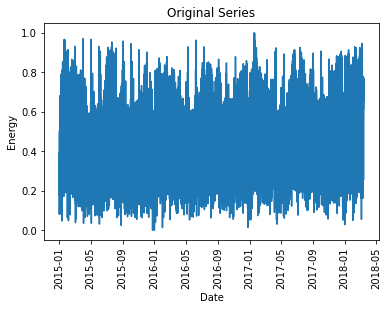

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.plot(traindf['actual'])

# Labelling 
plt.xlabel("Date")
plt.ylabel("Energy")
plt.title("Original Series")

# Display
plt.xticks(fontsize=10, rotation=90)
plt.show()

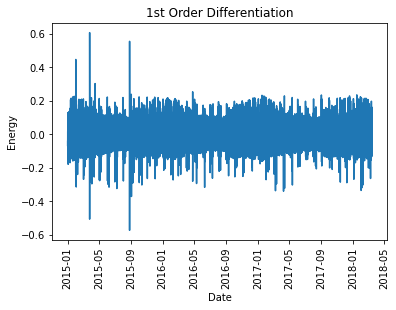

In [ ]:
plt.plot(traindf['actual'].diff())

# Labelling 
plt.xlabel("Date")
plt.ylabel("Energy")
plt.title("1st Order Differentiation")

# Display
plt.xticks(fontsize=10, rotation=90)
plt.show()

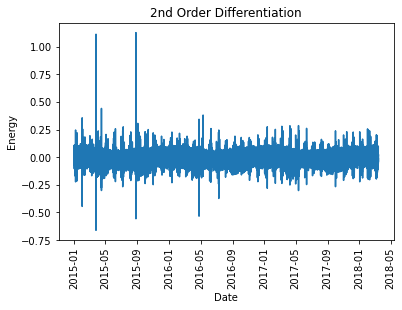

In [ ]:
plt.plot(traindf['actual'].diff().diff())

# Labelling 
plt.xlabel("Date")
plt.ylabel("Energy")
plt.title("2nd Order Differentiation")

# Display
plt.xticks(fontsize=10, rotation=90)
plt.show()

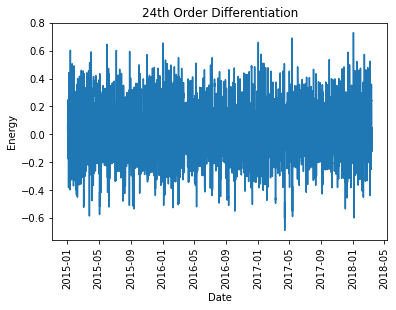

In [ ]:
plt.plot(traindf['actual'].diff(24))

# Labelling 
plt.xlabel("Date")
plt.ylabel("Energy")
plt.title("24th Order Differentiation")

# Display
plt.xticks(fontsize=10, rotation=90)
plt.show()

## Order of the AR term (p)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


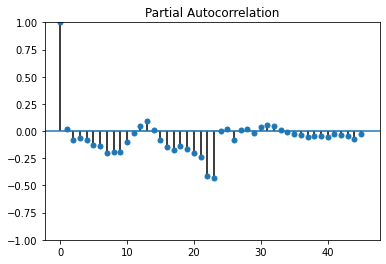

In [ ]:
import statsmodels.api as sm

sm.graphics.tsa.plot_pacf(traindf['actual'].diff().diff().dropna())

plt.show()
#Note that the PACF plot has a significant spike only at lag 1, meaning that all the higher-order autocorrelations are effectively explained by the lag-1 autocorrelation.

# Order of the MA term (q)

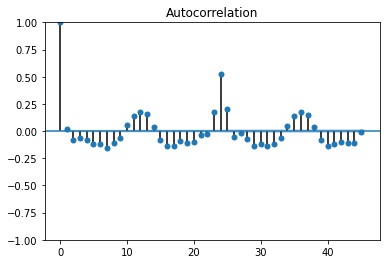

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(traindf['actual'].diff().diff().dropna())

plt.show()

In [ ]:
#If your series is slightly under differenced, adding one or more additional AR terms usually makes it up.
# Likewise, if it is slightly over-differenced, try adding an additional MA term.

# ARIMA model

In [ ]:
#from statsmodels.tsa.arima_model import ARIMA

# p,d,q = 2,1,2 ARIMA Model
#  (P,D,Q,s) order of the seasonal terms
# model = ARIMA(traindf['actual'], order=(24,2,5))
# model_fit = model.fit(disp=0)
# print(model_fit.summary())

In [ ]:
# Actual vs Fitted
#import matplotlib.pyplot as plt

# figure = model_fit.plot_predict(dynamic=False)
# figure.set_size_inches(10,6)

# plt.savefig("gdrive/MyDrive/data/dataset/train_forecast.png", dpi=300)
# plt.show()

In [ ]:
# history = traindf['actual'].fillna(method='bfill').reset_index(drop = True)
# test_act = testdf['actual'].fillna(method='bfill').reset_index(drop = True)
# predictions = list()
# obsersvations = list()

# for one_step in range(0, testdf.shape[0], 24):
#   model = ARIMA(history, order=())
#   model_fit = model.fit()
#   day_pred = model_fit.forecast(24)[0]
#   #y_pred[one_day:(one_day+24)] = day_pred
#   y_pred = np.hstack((y_pred, day_pred))
#   #y_pred.append(day_pred)
#   #print(len(y_pred))
#   history = np.concatenate((history, test_act[one_day:(one_day+24)]))



In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

statsmodels.__version__

'0.13.2'

In [ ]:
step=24
train=traindf['actual'].fillna(method='bfill').values
test =  testdf['actual'].fillna(method='bfill').values
history = [x for x in train]
predictions = list()
observations = list()

model = ARIMA(history, order=(24,2,2))
model_fit = model.fit()


In [ ]:
for t in range(len(test)-step):
    
    output = model_fit.forecast(step)
    yhat = output[step-1]
    if t%100==0:
        print(t)
    predictions.append(yhat)
    obs = test[t+step-1]
    observations.append(obs)
    model_fit=model_fit.append([test[t]])


# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mse = mean_squared_error(forecast, actual)   # MSE
    rmse = sqrt(mean_squared_error(forecast, actual))  # RMSE
  
    
    return({'mape':mape, 'mae': mae, 'mse': mse, 'rmse':rmse})

print(forecast_accuracy(np.array(predictions), np.array(observations)))  
#522 {'mape': 0.35924889336360655, 'mae': 0.1423103114002535, 'mse': 0.036115919634015926, 'rmse': 0.19004188915609085}
#2422 {'mape': 0.3957291717529868, 'mae': 0.16597459905158882, 'mse': 0.05502452992617101, 'rmse': 0.23457308013958253}

newdf = pd.DataFrame({'forecast':predictions, 'actual':observations})
newdf.to_csv("gdrive/MyDrive/data/dataset/results2422.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
{'mape': 0.3957291717529868, 'mae': 0.16597459905158882, 'mse': 0.05502452992617101, 'rmse': 0.23457308013958253}


In [ ]:
plt.plot(predictions,"r")
plt.plot(observations,"b")
plt.show()

In [ ]:
#testdf = pd.read_table("gdrive/MyDrive/data/dataset/results.csv", index_col = 0, sep = ",")

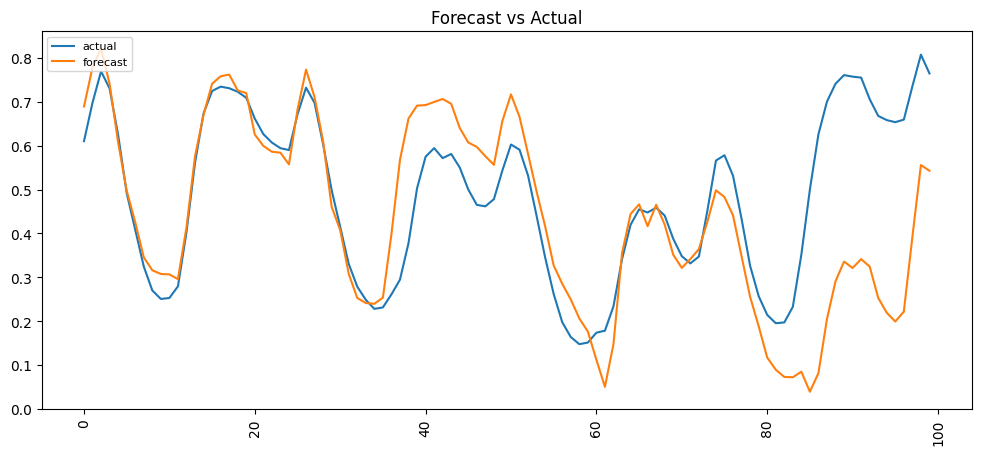

In [ ]:
subset = newdf.head(100)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(subset['actual'], label='actual')
plt.plot(subset['forecast'], label='forecast')

plt.title('Forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(fontsize=10, rotation=90)
#plt.xticks([])
plt.show()

# Metrics

# ARIMA (p, d, q) = (2, 0, 4)

{'mae': 0.16270087605947056,
 'mape': 0.5480413273486929,
 'me': 0.012320341077914165,
 'mpe': 0.3273750842238666,
 'rmse': 0.19494137980401147}

# ARIMA (p, d, q) = (5, 2, 2)

{'mape': 0.3679871313712261, 'me': -0.05575508527229874, 'mae': 0.12828895168520774, 'mpe': -0.055707703313283695, 'rmse': 0.15687852326407498}

In [ ]:
# Accuracy metrics
# def forecast_accuracy(forecast, actual):
#     mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
#     me = np.mean(forecast - actual)             # ME
#     mae = np.mean(np.abs(forecast - actual))    # MAE
#     mpe = np.mean((forecast - actual)/actual)   # MPE
#     rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    
    
#     return({'mape':mape, 'me':me, 'mae': mae, 
#             'mpe': mpe, 'rmse':rmse})

# forecast_accuracy(testdf['y_pred'], testdf['actual'])

{'mae': 0.16270087605947056,
 'mape': 0.5480413273486929,
 'me': 0.012320341077914165,
 'mpe': 0.3273750842238666,
 'rmse': 0.19494137980401147}